# ACSE-3 (Numerical Methods) <a class="tocSkip">

# Coursework 2 <a class="tocSkip">
    

# Instructions  <a class="tocSkip">
    

- This is the second of three equally weighted pieces of assessed coursework for this module.


- This is independent work, you cannot work in groups.


- There are two equally weighted questions below.


- You will be assessed on both your code as well as your supporting descriptions/discussions of the results you obtain.


- Submit your solutions as Jupyter notebooks via Github classroom - please submit a version where you have run all cells and the output/plots etc are visible.

# Coursework

## Coursework 2A - Advection-diffusion of a Gaussian


This question involves the solution of unsteady advection-diffusion in one spatial dimension using central finite difference schemes in space and explicit and implicit schemes in time.


- i. Write some code to implement the FTCS, BTCS, and Crank-Nicolson schemes (described in lecture 8) for advection-diffusion on a periodic domain. Verify the correctness of your implementations (you could use the following exact solution or any other way you see fit).


In the lecture 8 homework question 2 "An analytical solution to advection-diffusion" I explained how an appropriate Gaussian function can be considered as an exact solution to the advection-diffusion problem as long as we initialise our solution with the Gaussian evaluated at some $t>0$ (since in the limit of $t=0$ the solution is a Dirac-delta function). We can then use the same function evaluated at the appropriate time as an exact solution to compare our numerical method against.



- ii. Solve this problem using a Peclet number of 200, in a periodic domain of length 1, and advect long enough so that (given the periodic domain) the exact solution arrives back at the starting location.



- iii. What theoretical orders of accuracy do you expect for your three solvers with respect to the mesh spacing and the time step (i.e. assuming the error can be decomposed in the following way: $\,\text{error} = \mathcal{O}(\Delta x^p) +  \mathcal{O}(\Delta t^q)$, what do you expect $p$ and $q$ to be in each case?)



- iv. Confirm these orders of accuracy through convergence analyses of your three solvers by appropriately varying the mesh spacing and/or the time step in a series of experiments. (Note that you will need to deal with the periodic domain in your definition of the exact solution.)


## Coursework 2B - Variable mesh resolution

We said in lecture 7 that there were two approaches to achieve non-uniform or adaptive mesh resolution. 

In the lecture we went through the process of transforming and solving a problem in a computational domain. We applied our methodology to a BVP model problem of steady-state advection-diffusion with Dirichlet boundary conditions which led to a boundary layer at the right hand end of the domain (recall that this was a good test case as the problem has an analytical solution).

In this question we will consider the same model problem with the same parameters, i.e. a Peclet number of 30 and left and right boundary condition values of 0 and 1.

This coursework question is about the other approach where we prescribe a non-uniform mesh in physical space and update our finite difference solver to work with non-uniform resolution.

Your tasks are to: 


- i. perform this generalisation (i.e. you need to update our discretisation codes so that our finite difference formulae make use of the local mesh spacing $\Delta x_i:=x_{i+1}-x_i$, rather than assume it is a constant)

[Hint: don't forget to also update how you deal with the enforcement of BCs which for us here make use of ghost nodes. As the first node inside the domain changes its location, you either need to also update the ghost node location, or change the discretisation of the boundary condition so that it accounts for (e.g.) `x[0]` and `x[1]` being different distances from where our boundary is located.]


- ii. verify your code against (a) the original uniform mesh version, and (b) with a convergence analysis against the known analytical solution


- iii. generate a non-uniform mesh such that the arclength of the exact solution (i.e. in this part of the question you may assume knowledge of the exact solution) is approximately equal between mesh points, and compare the numerical solution obtained using this mesh and your new approach against uniform and optimal stretched meshes (i.e. using our function `BVP_AD_central_stretch_mesh`) in a convergence analysis.


- iv. investigate an approach where you start from a uniform mesh, solve the problem, subdivide certain computational cells if local steepness of the most recently computed numerical solution across that cell is higher than a user-defined tolerance, and then iterate by solving the problem on this new mesh and again subdividing. Can you come up with an approach that is competitive (in terms of a convergence plot) with the above approaches which were all able to make use of a priori knowledge of the solution behaviour?
[Hint: be careful to allow refinement close to the boundary, but not outside of the physical domain, i.e. you only want a single ghost node outside the physical domain at each boundary]

In [1]:
# Import libraries.
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sop
from scipy import interpolate

# Coursework 2A - Advection-diffusion of a Gaussian

The goal is to implement three different solutions, FTCS, BTCS and Crank-Nicolson, for the time-dependent advection-diffusion equation in one-dimension:

<br>

$$\frac{\partial c}{\partial t} + U\frac{\partial c}{\partial x} = \kappa\frac{\partial^2 c}{\partial x^2}.$$

<br>

To solve this PDE it is possible to adopt the method of lines. It consists in decoupling the space and time discretisation. The space discretisation is performed first, in this case using a finite difference method. This reduces the problem to a system of ODEs, which can be solved using a time stepping method like a linear multi-step method. The three schemes involved in the task employ the same space discretisation, central difference, and differ for what concern the time stepping.
<br>
<br>

## Space discretisation

<br>

The discretisation in space is achieved through a central difference. Considering a three point symmetric stencil, we can approximate a second derivative as:

<br>

\begin{align*} 
f''(x_i) 
& \approx g(\; f_{i-1}, \; f_{i}, \; f_{i+1}\; )\\[5pt]
& = a_{-1}\;f_{i-1}+ a_i\; f_{i} + a_{i+1}\; f_{i+1}.
\end{align*}

<br>

The coefficients $a$ are computed with the method of undetermined coefficients, which yields:

<br>

$$a_{-1}=\frac{1}{h^2},\;\;\;\;\;\; a_0 = -\frac{2}{h^2},\;\;\;\;\;\; a_1 = \frac{1}{h^2},$$

<br>

Substituting into the previous equation, we have:

<br>

$$ f''_i \approx \frac{f_{i+1} - 2f_i + f_{i-1}}{h^2}. $$

<br>

Such a discretisation achieves an accuracy of the second order and it is used to approximate the second derivative in the diffusion term:

<br>

$$ \left.\kappa\frac{\partial^2 c}{\partial x^2}\right|_{x_i} \approx \kappa\frac{c_{i+1} - 2c_i + c_{i-1}}{\Delta x^2}.$$

<br>

In order to be coherent for what concern the accuracy, we use the same method for the approximation of the first derivative in the advection term:

<br>

$$ \left.U\frac{\partial c}{\partial x}\right|_{x_i} \approx U\frac{c_{i+1} - c_{i-1}}{2\Delta x}.$$

<br>

## Time discretisation

### FTCS
Here we do time-stepping using the forward Euler method. The time derivative in the advection-diffusion equation is therefore approximated by:

<br>

$$ \left.\frac{\partial c}{\partial t}\right|_{t_i} \approx \frac{c^{t_i+\Delta t} - c^{t_i}}{\Delta t}.$$

<br>

This time stepping method is accurate to the first order.

### BTCS

The backward Euler method, also having a first order accuracy, is used in the discretisation:

<br>

$$ \left.\frac{\partial c}{\partial t}\right|_{t_i} \approx \frac{c^{t_i} - c^{t_i-\Delta t}}{\Delta t}.$$

<br>

### Crank-Nicolson

The method uses the trapezoidal rule to discretise time. It is accurate to the second order.

<br>

$$ \frac{c^{t_i+\Delta t}-c^{t_i}}{\Delta t} \approx \frac{1}{2}\;\left.\frac{\partial c}{\partial t}\right|_{t_i} + \frac{1}{2}\;\left.\frac{\partial c}{\partial t}\right|_{t_i+\Delta t}\;,$$

<br>

where the derivatives in $t_i$ and $t_i+\Delta t$ are approximated with the forward and backward Euler rules, respectively.

## Define functions we use for space discretisation

In [2]:
def adv_central_periodic(N):
    """ 
    Space discretisation of the advection term.
    Assumes central difference on a symmetric stencil with
    periodic boundary conditions
    
    Parameters
    ----------
    N : integer
        Number of nodes in the space mesh.

    Returns
    -------
    Dx : numpy array
        NxN array, space discretisation of the advection term.
    """
    Dx = 0.5*np.eye(N, k=1) - 0.5*np.eye(N, k=-1)
    Dx[0, -1] = -0.5
    Dx[-1, 0] = 0.5
    
    return Dx


def diff_central_periodic(N):
    """
    Space discretisation of the diffusion term.
    Assumes central difference on a symmetric stencil with
    periodic boundary conditions.
    
    Parameters
    ----------
    N : integer
        Number of nodes in the space mesh.

    Returns
    -------
    Dx : numpy array
        NxN array, space discretisation of the diffusion term.
    """
    Dxx = np.eye(N, k=1) - 2*np.eye(N) + np.eye(N, k=-1)
    Dxx[0, -1] = 1
    Dxx[-1, 0] = 1
    
    return Dxx


## Implement analytical solution

In [3]:
def adv_diff_analytical_solution(U, kappa, x0, x, t):
    """
    Analtical solution of the advection-diffusion problem.
    Assumes a Dirac-delta function as initial condition(t=0).
    
    Parameters
    ----------
    U : float
        Speed of advection.
    kappa : float
        Diffusivity.
    x0 : float
        Starting point (in space) of the solution.
    x : numpy vector
        Position of the space nodes.
    t : float
        Time at which the solution is evaluated.
    
    Returns
    -------
    Function defining the analytical solution at time t and space given by
    the x vector.
    """
    
    return np.exp( -((x-x0) - U*t)**2 / (4.*kappa*t)) / np.sqrt(4. * np.pi * kappa * t)


## Implement the three solvers

In [4]:
def solver_FTCS(N, dt, t_start, t_end, U, kappa):
    """
    Implement solution with:
    Space discretisation --> central difference
    Time discretisation --> forward Euler
    
    Parameters
    ----------
    N : integer
        Number of nodes in space.
    dt : float
        Time step size.
    t_start : float
        Initial time of the simulation.
    t_end : float
        End time of the simulation.
    U : float
        Speed of advection.
    kappa : float
        Diffusivity.
    
    Returns
    -------
    C_ft : numpy 1D array
        Values of the solution.
    x : numpy 1D array
        Space values where solution is evaluated.
    t : numpy 1D array
        Time values when solution is evaluated.
    """

    # Spatial mesh.
    dx = L/N
    x = np.linspace(0, L, N)

    # Get the discretisation matrix.
    Dx = adv_central_periodic(N)
    Dxx = diff_central_periodic(N)
    A = -(U / dx) * Dx + (kappa / dx**2) * Dxx

    # Time vector.
    t = np.arange(t_start, t_end, dt)

    # Matrix to store the discretised solution.
    C_ft = np.empty((len(x), len(t)))

    # Define an initial condition.
    # # Gaussian shape.
    # C_ft[:, 0] = np.exp( - ((x-0.2)/0.05)**2 )
    # Or get the analytical solution.
    C_ft[:,0] = adv_diff_analytical_solution(U, kappa, x0, x, t_start)

    # Get the solution at the values of time.
    I = np.eye(len(x))
    for n in range(len(t)-1):
        C_ft[:, n+1] = np.matmul((I + A * dt), C_ft[:, n])

     # # Save the FTCS solution.
     # np.save('C_ft',C_ft)

    return C_ft, x, t


In [5]:
def solver_BTCS(N, dt, t_start, t_end, U, kappa):
    """
    Implement solution with:
    Space discretisation --> central difference 
    Time discretisation --> backward Euler
    
    Parameters
    ----------
    N : integer
        Number of nodes in space.
    dt : float
        Time step size.
    t_start : float
        Initial time of the simulation.
    t_end : float
        End time of the simulation.
    U : float
        Speed of advection.
    kappa : float
        Diffusivity.
    
    Returns
    -------
    C_bt : numpy 1D array
        Values of the solution.
    x : numpy 1D array
        Space values where solution is evaluated.
    t : numpy 1D array
        Time values when solution is evaluated.
    """

    # Define the spatial mesh.
    dx = L / N
    x = np.linspace(0, L, N)

    # Get the discretisation matrix.
    Dx = adv_central_periodic(N)
    Dxx = diff_central_periodic(N)
    A = -(U / dx) * Dx + (kappa / dx**2) * Dxx

    # Get the time vector.
    t = np.arange(t_start, t_end, dt)
    
    # Matrix to store the discretised solution.
    C_bt = np.empty((len(x), len(t)))

    # Define an initial condition.
    # # Gaussian shape.
    # C_bt[:, 0] = np.exp( - ((x-0.2)/0.05)**2 )
    # Or get the analytical solution.
    C_bt[:,0] = adv_diff_analytical_solution(U, kappa, x0, x, t_start)

    # Get the BTCS solution at the values of time.
    # Use optimize.root. Previous state as initial guess.
    for n in range(len(t)-1):
        def bf(x):
            """
            Arrange the backward Euler formula as a root problem.
            """
            bf = np.zeros_like(x)
            bf = C_n + (A*dt)@x - x
            return bf
        C_n = C_bt[:, n]
        sol = sop.root(bf, C_n)
        C_bt[:, n+1] = sol.x

    # Save the BTCS solution.
    # np.save('C_bt', C_bt)

    return C_bt, x, t


In [6]:
def solver_CN(N, dt, t_start, t_end, U, kappa):
    """
    Implement solution with:
    Space discretisation --> central difference 
    Time discretisation --> trapezoidal rule
    
    Parameters
    ----------
    N : integer
        Number of nodes in space.
    dt : float
        Time step size.
    t_start : float
        Initial time of the simulation.
    t_end : float
        End time of the simulation.
    U : float
        Speed of advection.
    kappa : float
        Diffusivity.
    
    Returns
    -------
    C_cn : numpy 1D array
        Values of the solution.
    x : numpy 1D array
        Space values where solution is evaluated.
    t : numpy 1D array
        Time values when solution is evaluated.
    """

    # Define the spatial mesh.
    dx = L / N
    x = np.linspace(0, L, N)

    # Get the discretisation matrix.
    Dx = adv_central_periodic(N)
    Dxx = diff_central_periodic(N)
    A = -(U / dx) * Dx + (kappa / dx**2) * Dxx

    # Get the time vector.
    t = np.arange(t_start, t_end, dt)

    # Matrix to store the discretised solution.
    C_cn = np.empty((len(x), len(t)))

    # Define an initial condition.
    # # Gaussian shape.
    # C_cn[:, 0] = np.exp( - ((x-0.2)/0.05)**2 )
    # Or get the analytical solution.
    C_cn[:,0] = adv_diff_analytical_solution(U, kappa, x0, x, t_start)

    # # Get the Crank-Nicolson solution.
    # # Use optimize.root. Previous state as initial guess.
    for n in range(len(t)-1):
        def am1(x):
            """
            Arrange the AM1 formula as a root problem.
            """
            am1 = np.zeros_like(x)
            am1 = -x + C_n + ((.5*dt)*A)@x + ((.5*dt)*A)@C_n
            return am1
        C_n = C_cn[:, n]
        sol = sop.root(am1, C_n)
        C_cn[:, n+1] = sol.x

    # # Save the Crank-Nicolson solution.
    # np.save('C_cn', C_cn)

    return C_cn, x, t    


## Run solvers and plot the solutions

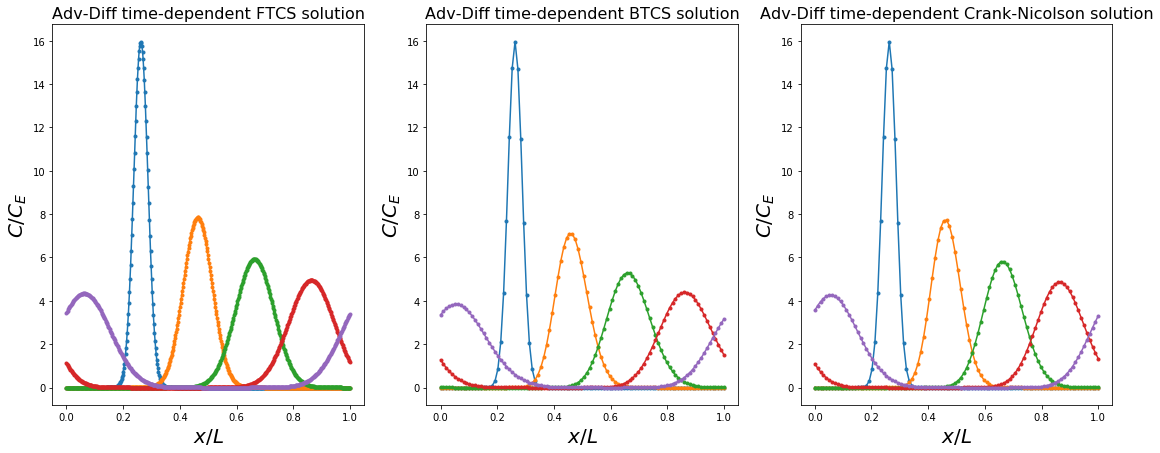

In [7]:
# Set up figure.
ax = np.array([0, 1, 2])
fig, ax = plt.subplots(1, 3, figsize=(19, 7))
for l in range(len(ax)):
    ax[l].set_xlabel('$x/L$', fontsize = 20)
    ax[l].set_ylabel('$C/C_E$', fontsize = 20)
    # ax[l].set_xlim(0, 1)
    # ax[l].set_ylim(-0.1, 1.1)



U = .25
L = 1.
Pe = 200.
kappa = U*L/Pe
N = 500
dx = L / N
dt = 0.001
t_start = 0.25
t_end = t_start + 4
x0 = 0.2

# print('Pe_c: {0:.5f}'.format(U*dx/kappa))
# print('CFL:  {0:.5f}'.format(U*dt/dx))
# print('r:    {0:.5f}'.format(kappa*dt/(dx**2)))

C_ft, x, t = solver_FTCS(N, dt, t_start, t_end, U, kappa)

# FTCS.
# C_ft = np.load('C_ft.npy')
ax[0].set_title('Adv-Diff time-dependent FTCS solution', fontsize = 16)
for i in np.arange(0, len(t), int(len(t)/5)):
    ax[0].plot(x, C_ft[:, i], '.-')



U = .25
L = 1.
Pe = 200.
kappa = U*L/Pe
N = 100
dx = L / N
dt = 0.01
t_start = 0.25
t_end = t_start + 4
x0 = 0.2

C_bt, x, t = solver_BTCS(N, dt, t_start, t_end, U, kappa)

# BTCS.
# C_bt = np.load('C_bt.npy')
ax[1].set_title('Adv-Diff time-dependent BTCS solution', fontsize = 16)
for i in np.arange(0, len(t), int(len(t)/5)):
    ax[1].plot(x, C_bt[:, i], '.-')



U = .25
L = 1.
Pe = 200.
kappa = U*L/Pe
N = 100
dx = L / N
dt = 0.01
t_start = 0.25
t_end = t_start + 4
x0 = 0.2

C_cn, x, t = solver_CN(N, dt, t_start, t_end, U, kappa)

# Crank-Nicolson.
# C_cn = np.load('C_cn.npy')
ax[2].set_title('Adv-Diff time-dependent Crank-Nicolson solution', fontsize = 16)
for i in np.arange(0, len(t), int(len(t)/5)):
    ax[2].plot(x, C_cn[:, i], '.-')


## Implement a periodic analytical solution

In order to model periodic boundaries for the analytical solution I use a simple approach in which, at each time step, the portion of solution that has left the domain on the right is copied on the left side of the domain.

In [8]:
# Get periodic analytical solution.
def analytical_periodic(N, U, kappa, x0, x, t_start, t_end, dt):
    """
    Implement the analytical solution taking into account the periodic boundaries.
    
    Parameters
    ----------
    N : integer
        Number of nodes in space.
    U : float
        Speed of advection.
    kappa : float
        Diffusivity.
    x0 : float
        Initial point (in space) of the solution.
    t_start : float
        Initial time of the simulation.
    t_end : float
        End time of the simulation.
    dt : float
        Time step size.

    Returns
    -------
    C_exa_1 : numpy 1D array
        Values of the analytical solution.
    """
    t_vec = np.arange(t_start, t_end, dt)
    C_exa = np.empty((len(x), len(t_vec)))
    C_exa_1 = np.empty((len(x), len(t_vec)))
    C_exa[:, 0] = adv_diff_analytical_solution(U, kappa, x0, x, t_vec[0])
    C_exa_1[:, 0] = adv_diff_analytical_solution(U, kappa, x0, x, t_vec[0])
    for i in range(1, len(t_vec)):
        C_exa[:, i] = adv_diff_analytical_solution(U, kappa, x0, x, t_vec[i])
        C_exa_1[i:, i] = C_exa[0:-i,i]
        C_exa_1[0:i, i] = C_exa[-i:,i]
        x0 = x0 - U*dt

    return C_exa_1


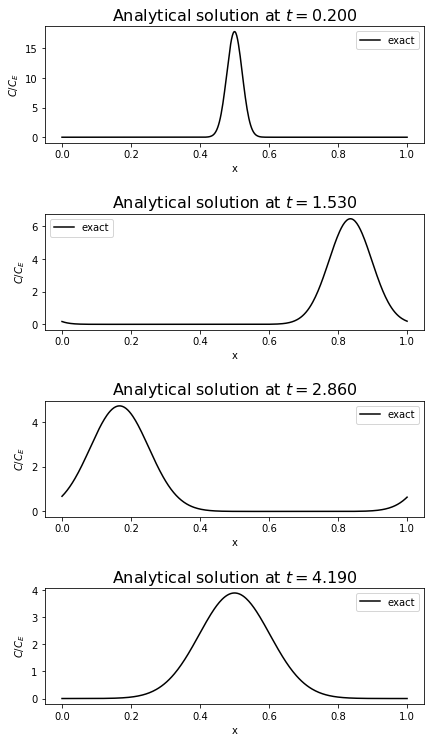

In [9]:
# parameters
U = .25
L = 1.
Pe = 200.
kappa = U*L/Pe
N = 100
dx = L / N
dt = 0.01
t_start = 0.2
t_end = t_start + 4
t = np.arange(t_start, t_end, dt)
x0 = 0.45

x_ini = np.linspace(0, L, N)

# get periodic exact solution.
dx_exa = U*dt
N_exa = int(L/dx_exa)
x_exa = np.linspace(0, L, N_exa)
C_exa = analytical_periodic(N_exa, U, kappa, x0, x_exa, t_start, t_end, dt)


fig, axs = plt.subplots(4, 1, figsize=(6, 10))
axs = axs.reshape(-1)
fig.tight_layout(w_pad=4, h_pad=5)
for i, n in enumerate(np.linspace(0, len(t)-1, 4, dtype = int)):
    axs[i].plot(x_exa, C_exa[:, n], 'k-', label='exact')
    axs[i].legend(loc = 'best')
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('$C/C_E$')
    axs[i].set_title('Analytical solution at $t=${0:.3f}'.format(t[n]), fontsize = 16)


## Comments on the figure

The figure shows the analytical solution at different time steps considering periodic boundary conditions.

## Compare analytical and FTCS solution

Pe_c: 0.40000
CFL:  0.12500
r:    0.31250


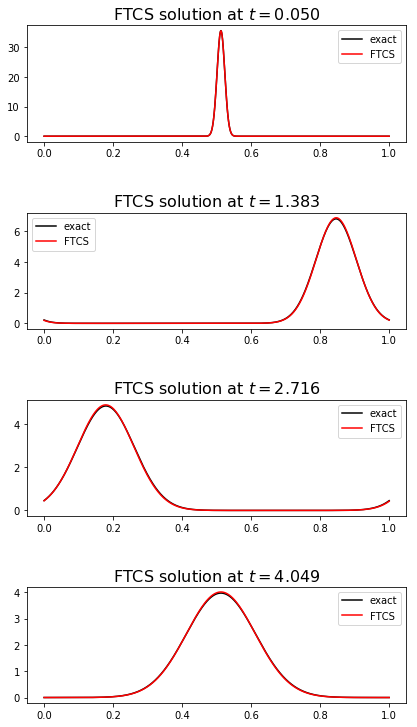

In [10]:
# parameters
U = .25
L = 1.
Pe = 200.
kappa = U*L/Pe
N = 500
dx = L / N
dt = 0.001
t_start = 0.05
t_end = t_start + 4
x0 = 0.5

# Plot parameters to check stability.
print('Pe_c: {0:.5f}'.format(U*dx/kappa))
print('CFL:  {0:.5f}'.format(U*dt/dx))
print('r:    {0:.5f}'.format(kappa*dt/(dx**2)))

# FTCS.
C_ft, x, t = solver_FTCS(N, dt, t_start, t_end, U, kappa)

# Get exact solution.
dx_exa = U*dt
N_exa = int(L/dx_exa)
x_exa = np.linspace(0, L, N_exa)
# C_exact = analytical_periodic(N, U, kappa, x0, x, t_start, t_end, dt)
C_exact = analytical_periodic(N_exa, U, kappa, x0, x_exa, t_start, t_end, dt)

fig, axs = plt.subplots(4, 1, figsize=(6, 10))
axs = axs.reshape(-1)
fig.tight_layout(w_pad=4, h_pad=5)
for i, n in enumerate(np.linspace(0, len(t)-1, 4, dtype=int)):
    # axs[i].plot(x, C_exact[:, n], 'k-', label='exact')
    axs[i].plot(x_exa, C_exact[:, n], 'k-', label='exact')
    axs[i].plot(x, C_ft[:, n], 'r-', label='FTCS')
    axs[i].legend(loc='best')
    axs[i].set_title('FTCS solution at $t=${0:.3f}'.format(t[n]), fontsize=16)


## Compare analytical and BTCS solution

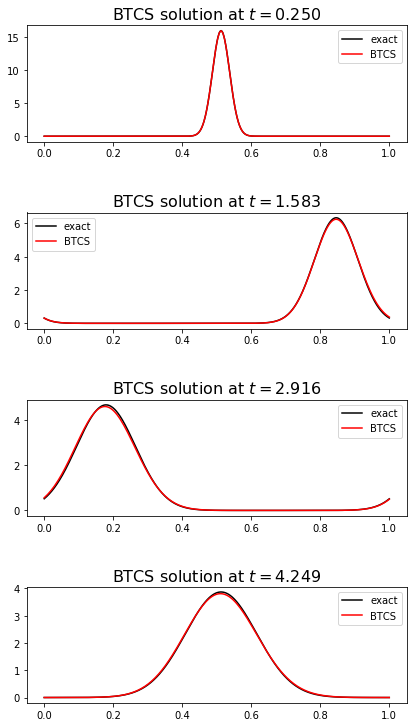

In [11]:
U = .25
L = 1.
Pe = 200.
kappa = U*L/Pe
N = 200
dx = L / N
dt = 0.001
t_start = 0.25
t_end = t_start + 4
x0 = 0.45

C, x, t = solver_BTCS(N, dt, t_start, t_end, U, kappa)

# Get exact solution.
dx_exa = U*dt
N_exa = int(L/dx_exa)
x_exa = np.linspace(0, L, N_exa)
C_exact = analytical_periodic(N_exa, U, kappa, x0, x_exa, t_start, t_end, dt)

fig, axs = plt.subplots(4, 1, figsize=(6, 10))
axs = axs.reshape(-1)
fig.tight_layout(w_pad=4, h_pad=5)
for i, n in enumerate(np.linspace(0, len(t)-1, 4, dtype=int)):
    axs[i].plot(x_exa, C_exact[:, n], 'k-', label='exact')
    axs[i].plot(x, C[:, n], 'r-', label='BTCS')
    axs[i].legend(loc='best')
    axs[i].set_title('BTCS solution at $t=${0:.3f}'.format(t[n]), fontsize=16)

## Compare analytical and Crank-Nicolson solution

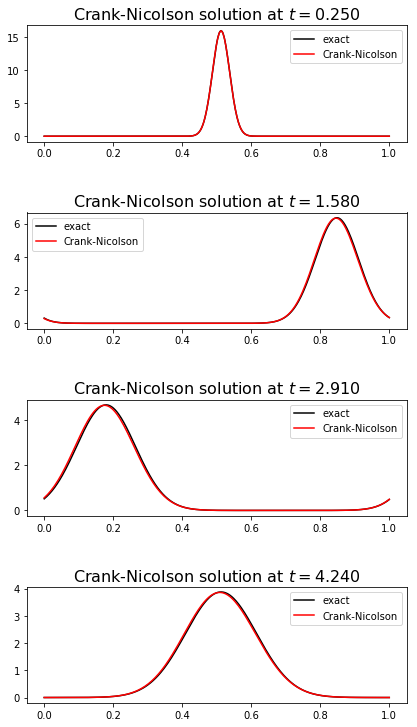

In [13]:
U = .25
L = 1.
Pe = 200.
kappa = U*L/Pe
N = 200
dx = L / N
dt = 0.01
t_start = 0.25
t_end = t_start + 4
x0 = 0.45

C, x, t = solver_CN(N, dt, t_start, t_end, U, kappa)

# Get exact solution.
dx_exa = U*dt
N_exa = int(L/dx_exa)
x_exa = np.linspace(0, L, N_exa)
C_exact = analytical_periodic(N_exa, U, kappa, x0, x_exa, t_start, t_end, dt)

fig, axs = plt.subplots(4, 1, figsize=(6, 10))
axs = axs.reshape(-1)
fig.tight_layout(w_pad=4, h_pad=5)
for i, n in enumerate(np.linspace(0, len(t)-1, 4, dtype=int)):
    axs[i].plot(x_exa, C_exact[:, n], 'k-', label='exact')
    axs[i].plot(x, C[:, n], 'r-', label='Crank-Nicolson')
    axs[i].legend(loc='best')
    axs[i].set_title('Crank-Nicolson solution at $t=${0:.3f}'.format(t[n]), fontsize=16)

## Theoretical order of accuracy

The three implemented schemes have the same space discretisation, a central difference on a symmetric stencil formed by three nodes. Such a method is accurate to the second order. The methods FTCS and BTCS employ forward Euler and backward Euler, respectively, to perform the time discretisation. Both backward and forward Euler are first order accurate.<br>
Assuming we can decouple the error in two terms, one proportional to the space step size, and the other one proportional to the time step size, the order of accuracy of FTCS and BTCS con be defined as:

<br>
$$\text{error} = \mathcal{O}(\Delta x^2) + \mathcal{O}(\Delta t).$$
<br>

Considering that $\Delta x$ and $\Delta t$ are usually much lower than one, the error will be dominated by the time step size. FTCS and BTCS are therefore expected to be first order accurate.<br>

In the Crank-Nicolson method, central difference is again used for the space discretisation, and the trapezoidal scheme is used in the time discretisation. This method is therefore expected to be second order accurate both in space and in time. Using the previous equation and substituting the proper orders, we get:

<br>
$$\text{error} = \mathcal{O}(\Delta x^2) + \mathcal{O}(\Delta t^2).$$
<br>


## Convergence analysis of the FTCS method

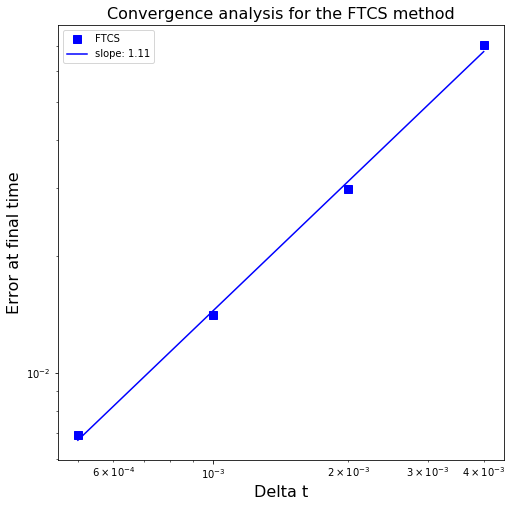

In [19]:
U = .25
L = 1.
Pe = 200.
kappa = U*L/Pe
N = 100
dt = 0.004
t_start = 0.2
t_end = t_start + 4
x0 = 0.45
n_ite = 4

err_all = []
N_all = []
dt_all = []

for i in range(n_ite):
    
    C, x, t = solver_FTCS(N, dt, t_start, t_end, U, kappa)
    
    dx_exa = U*dt
    N_exa = int(L/dx_exa)
    x_exa = np.linspace(0, L, N_exa)
    C_exa = analytical_periodic(N_exa, U, kappa, x0, x_exa, t_start, t_end, dt)
    # interpolate back to initial mesh
    c_exa = np.empty((len(x_exa)))
    c_exa = C_exa[:, -1]
    f = interpolate.interp1d(x_exa, c_exa)
    c_exa = f(x)

    # Error: root mean square of the errors.
    err = np.sqrt(np.mean( (C[:, -1] - c_exa)**2 ))
    
    err_all.append(err)
    
    N_all.append(N)
    dt_all.append(dt)
    N = N*2
    dt = dt/2


fig = plt.figure(figsize = (8, 8))
ax1 = plt.subplot(111)
ax1.loglog(dt_all, err_all, 'bs', label = 'FTCS', markersize = 8)

# Get a linear fit to the errors using numpy.polyfit.
fit = np.polyfit(np.log(dt_all), np.log(err_all), 1)
ax1.loglog(dt_all, np.exp(fit[1]) * dt_all**(fit[0]), 'b-', label = 'slope: {:.2f}'.format(fit[0]))
ax1.legend(loc = 'best')

ax1.set_xlabel('Delta t', fontsize = 16)
ax1.set_ylabel('Error at final time', fontsize = 16)
ax1.set_title('Convergence analysis for the FTCS method', fontsize = 16)

plt.show()

## Comments on the figure

As expected from theoretical considerations, the error is dominated by its time component and the method is therefore first order accurate.

## Convergence analysis of the BTCS method

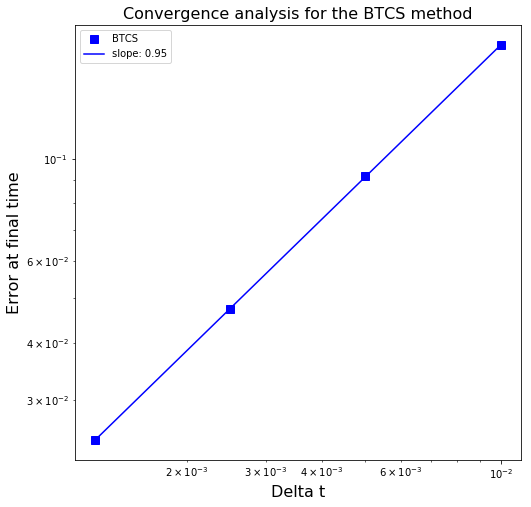

In [49]:
# Parameters
U = .25
L = 1.
Pe = 200.
kappa = U*L/Pe
N = 100
dt = 0.01
t_start = 0.2
t_end = t_start + 4
x0 = 0.25
n_ite = 4

err_all = []
N_all = []
dt_all = []

for i in range(n_ite):
    
    C, x, t = solver_BTCS(N, dt, t_start, t_end, U, kappa)

    dx_exa = U*dt
    N_exa = int(L/dx_exa)
    x_exa = np.linspace(0, L, N_exa)
    C_exa = analytical_periodic(N_exa, U, kappa, x0, x_exa, t_start, t_end, dt)
    # interpolate back to initial mesh
    c_exa = np.empty((len(x_exa)))
    c_exa = C_exa[:, -1]
    f = interpolate.interp1d(x_exa, c_exa)
    c_exa = f(x)

    # # Error: root mean square of the errors.
    err = np.sqrt(np.mean( (C[:, -1] - c_exa)**2 ))
    err_all.append(err)

    N_all.append(N)
    dt_all.append(dt)
    N = N*2
    dt = dt/2

fig = plt.figure(figsize = (8, 8))
ax1 = plt.subplot(111)
ax1.loglog(dt_all, err_all, 'bs', label = 'BTCS', markersize = 8)

# Get a linear fit to the errors using numpy.polyfit.
fit = np.polyfit(np.log(dt_all[:]), np.log(err_all[:]), 1)
ax1.loglog(dt_all, np.exp(fit[1]) * dt_all**(fit[0]), 'b-', label = 'slope: {:.2f}'.format(fit[0]))
ax1.legend(loc = 'best')

ax1.set_xlabel('Delta t', fontsize = 16)
ax1.set_ylabel('Error at final time', fontsize = 16)
ax1.set_title('Convergence analysis for the BTCS method', fontsize = 16)

plt.show()


## Comments on the figure

As for the FTCS method, even in this case the error is dominated by the time component and the method is first order accurate.

## Convergence analysis for the Crank-Nicolson method

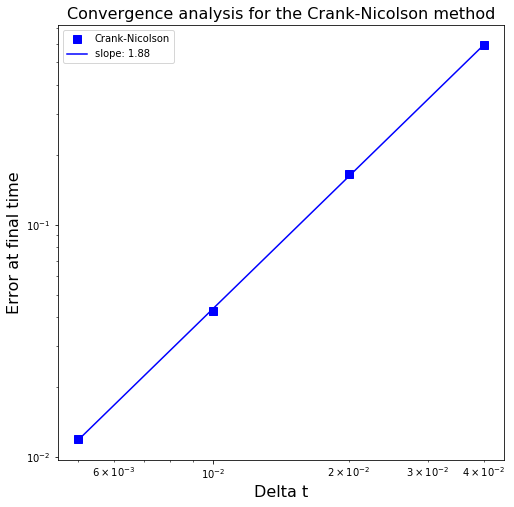

In [42]:
U = .25
L = 1.
Pe = 200.
kappa = U*L/Pe
N = 25
dt = 0.04
t_start = 0.25
t_end = t_start + 4
x0 = 0.45
n_ite = 4


err_all = []
N_all = []
dt_all = []
dx_all = []

for i in range(n_ite):
    
    C, x, t = solver_CN(N, dt, t_start, t_end, U, kappa)

    dx_exa = U*dt
    N_exa = int(L/dx_exa)
    x_exa = np.linspace(0, L, N_exa)
    C_exa = analytical_periodic(N_exa, U, kappa, x0, x_exa, t_start, t_end, dt)
    # interpolate back to initial mesh
    c_exa = np.empty((len(x_exa)))
    c_exa = C_exa[:, -1]
    f = interpolate.interp1d(x_exa, c_exa)
    c_exa = f(x)

    # Error: root mean square of the errors.
    err = np.sqrt(np.mean( (C[:, -1] - c_exa)**2 ))
    err_all.append(err)
    
    N_all.append(N)
    dt_all.append(dt)
    dx = L / N
    dx_all.append(dx)
    
    N = N*2
    dt = dt/4


# Plot error as function of dt.

fig = plt.figure(figsize = (8, 8))
ax1 = plt.subplot(111)
ax1.loglog(dx_all, err_all, 'bs', label = 'Crank-Nicolson', markersize = 8)

# Get a linear fit to the errors using numpy.polyfit.
fit = np.polyfit(np.log(dx_all), np.log(err_all), 1)
ax1.loglog(dx_all, np.exp(fit[1]) * dx_all**(fit[0]), 'b-', label = 'slope: {:.2f}'.format(fit[0]))
ax1.legend(loc = 'best')

ax1.set_xlabel('Delta t', fontsize = 16)
ax1.set_ylabel('Error at final time', fontsize = 16)
ax1.set_title('Convergence analysis for the Crank-Nicolson method', fontsize = 16)

plt.show()

## Comments on the figure

The slope of the linear fit is roughly equals to $2$, in accordance with the fact that the Crank-Nicolson method is second order accurate in both space and time.

# Coursework 2B - Variable mesh resolution

## i.

## Assemble and solve the AD BVP problem on a general 1D mesh

In lecture 7, we used the method of undetermined coefficients to perform a discretisation of the second derivative on a three-nodes symmetric stencil. Here I use the same method to obtain a discretisation on a general 3 nodes stencil, without assuming it symmetric.<br>

In the method of undetermined coefficients we approximate a certain derivative of a function through the values of the same function in neighboring locations (which will be the nodes of the stencil). The general formula is:

<br>
$$ f^{(n)}(x_i) \approx g(\ldots,\; f_{i-2}, \; f_{i-1}, \; f_{i}, \; f_{i+1}, \; f_{i+2}, \; \ldots). $$
<br>

For a second order derivative and a three-nodes stencil, we have:

<br>
$$ f''(x_i) \approx g(\; f_{i-1}, \; f_{i}, \; f_{i+1}\; ). $$
<br>

In a finite difference scheme, $g$ is a linear function, so we have:

<br> 
$$ g(\; f_{i-1}, \; f_{i}, \; f_{i+1}\; )= a_{i-1}\;f_{i-1}+ a_i\; f_{i} + a_{i+1}\; f_{i+1}. $$
<br>

We need to find the coefficients $a$ considering a general stencil where the distance between nodes $i-1$ and $i$, and the distance between nodes $i$ and $i+1$, might no be the same. To find the coefficents we start by defining $f_{i-1}$ and $f_{i+1}$ using Taylor series:

<br>
\begin{align}
f_{i-1} &= f_i - h_j f'_i + \frac{h_j^2}{2} f''_{i} + \mathcal{O}(h_j^3),\\[10pt]
f_{i+1} &= f_i + h_{j+1} f'_i + \frac{h_{j+1}^2}{2} f''_{i} + \mathcal{O}(h_{j+1}^3),
\end{align}
<br>

substituting into the formula given for $g$ and collecting terms we get:

<br>
\begin{align*}
f''_i & = (a_{i-1} + a_i + a_{i+1})f_i + (a_{i+1}h_{j+1} - a_{i-1}h_j)f'_i + (a_{i+1}\frac{h_{j+1}^2}{2} + a_{i-1}\frac{h_{j}^2}{2})\;f''_i + \mathcal{O}(h^3).
\end{align*}
<br>

The RHS of the above equation properly approximate the second order derivative if:

<br>
$$ a_{i-1} + a_i + a_{i+1}=0, \;\;\;\;\;\;
a_{i+1}h_{j+1} - a_{i-1}h_j = 0, \;\;\;\;\;\;
a_{i+1}\frac{h_{j+1}^2}{2} + a_{i-1}\frac{h_{j}^2}{2} = 1. $$
<br>

Writing the three equations above in a matrix system (see below), we can obtain the $a$ coeffients using the numpy linear algebra library.

<br>
$$
\begin{pmatrix}
1 & 1 & 1 \\
h_j & 0 & h_{j+1} \\
\frac{h_{j}^2}{2} & 0 & \frac{h_{j+1}^2}{2}
\end{pmatrix}
\begin{pmatrix}
a_{i-1}\\
a_i\\
a_{i+1}
\end{pmatrix}
=
\begin{pmatrix}
0\\
0\\
1
\end{pmatrix}
$$

<br>
<br>
## Dealing with Dirichlet boundary conditions

Since the stencil might not be symmetric, when setting up the boundary conditions we need to take into account the possiblity that the distance between the left ghost node and the boundary is not equal to the distance between boundary and first interior node. Also, on the other side of the domain, the distance between the last interior node and the boundary might not be equal to the distance between the boundary and the right ghost node.<br>
In the Dirichlet form, the boundary conditions for our problem are:

<br>
$$C(0,t) = 0, \;\;\;\; C(L,t) = C_E, $$
<br>

where $L$ indicate the lenght of the domain, which starts at $x=0$. The conditions can be approximated with a linear interpolation. For the left boundary condition we have:

<br>
$$ \frac{C_{bl}-C_0}{\Delta x_{bl}} = \frac{C_1-C_0}{\Delta x_0} \;\; \implies
C_{bl} = (1-\frac{\Delta x_{bl}}{\Delta x_0})\;C_0 + \frac{\Delta x_{bl}}{\Delta x_0}\;C_1, $$
<br>

where $C_{bl}$ indicates the value of the function at the left border (in this case $= 0$), $\Delta x_{bl}$ is the distance between left ghost node ($C_0$) and the left boundary, $\Delta x_0$ is the distance between $C_0$ and the first interior node ($C_1$). Adopting the same approach for the right boundary condition we have:

<br>
$$ \frac{C_{br}-C_N}{\Delta x_{br}} = \frac{C_{N+1}-C_N}{\Delta x_j} \;\; \implies
C_{br} = (1-\frac{\Delta x_{br}}{\Delta x_j})\;C_N + \frac{\Delta x_{br}}{\Delta x_j}\;C_{N+1}, $$
<br>

with $C_{br}$ indicating the value of the function at the right border (in this case $= C_E$), $\Delta x_{br}$ the distance between the right most interior node ($C_N$) and the right boundary, $\Delta x_j$ the distance between $C_N$ and the right ghost node ($C_{N+1}$).

In [22]:
def BVP_AD_central(x, L, U, kappa, CE, N):    
    """
    Assemble and solve the AD BVP problem using central
    differences for both advection and diffusion on a stencil
    of general shape.
    
    Parameters
    ----------
    x : numpy 1D array
        Space mesh.
    L : float
        Length of the domain.
    U : float
        Speed of advection.
    kappa : float
        Diffusivity.
    CE : float
        Right boundary condition.
    N : integer
        Number of nodes in space.

    Returns
    -------
    C : numpy 1D array
        Values of the solution.
    """
    
    dx_ind = np.linspace(0, len(x)-2, len(x)-1)
    
    # Get the delta x vector.
    dx_vec = np.empty((len(dx_ind)))
    for i in range(1, len(x)):
        dx_vec[i-1] = x[i] - x[i-1]

    # get the distance between left ghost node and left boundary
    lbx = -x[0]
    # get the distance between the node N and the right boundary
    rbx = dx_vec[-1] - (x[-1] - L)

    A = np.zeros((N + 2, N + 2))
    b = np.zeros((N + 2))
    # interior points
    for i in range(1, N + 1):
        LHS = np.array([ [1, 1, 1], [0, dx_vec[i], -dx_vec[i-1]], [0, (dx_vec[i]**2)/2, (dx_vec[i-1]**2)/2]])
        RHS = np.array([0, 0, 1])
        a_coe = np.linalg.solve(LHS, RHS)
        A[i, i - 1] = a_coe[2] * kappa + (1/(dx_vec[i]+dx_vec[i-1])) * U
        A[i, i] = a_coe[0] * kappa
        A[i, i + 1] = a_coe[1] * kappa - (1/(dx_vec[i]+dx_vec[i-1])) * U
        b[i] = 0
    # BC1
    A[0, 0] = 1 - lbx/dx_vec[0]
    A[0, 1] = lbx/dx_vec[0]
    b[0] = 0
    # BC2
    A[N + 1, N] = 1 - rbx/dx_vec[-1]
    A[N + 1, N + 1] = rbx/dx_vec[-1]
    b[N + 1] = CE  # BC2
    # invert matrix
    C = np.linalg.solve(A, b)

    return C


## Original function, from lecture 7, for uniform mesh

In [23]:
def BVP_AD_central_unimesh(L, U, kappa, CE, N):
    """
    Assemble and solve the AD BVP problem using central
    differences for both advection and diffusion on a symmetric stencil.
    
    Parameters
    ----------
    L : float
        Length of the domain.
    U : float
        Speed of advection.
    kappa : float
        Diffusivity.
    CE : float
        Right boundary condition.
    N : integer
        Number of nodes in space.

    Returns
    -------
    x : numpy 1D array
        Space mesh (uniform).
    C : numpy 1D array
        Values of the solution.
    """

    dx = L / N
    x = np.linspace(-dx / 2, dx / 2 + L, N + 2)
    A = np.zeros((N + 2, N + 2))
    b = np.zeros((N + 2))
    # interior points
    r_diff = kappa / dx**2
    r_adv = 0.5 * U / dx
    for i in range(1, N + 1):
        A[i, i - 1] = r_diff + r_adv
        A[i, i] = -2 * r_diff
        A[i, i + 1] = r_diff - r_adv
        b[i] = 0
    # BC1
    A[0, 0] = 0.5
    A[0, 1] = 0.5
    b[0] = 0
    # BC2
    A[N + 1, N] = 0.5
    A[N + 1, N + 1] = 0.5
    b[N + 1] = CE  # BC2
    # invert matrix
    C = np.linalg.solve(A, b)

    return x, C

## ii.

## Comparison between original and generalised functions

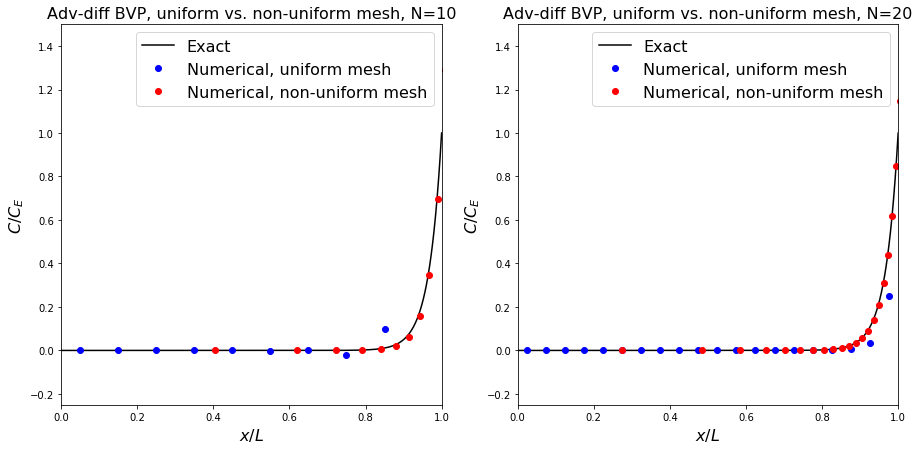

In [24]:
# parameters
L = 1.
U = 1.
Pe = 30.
kappa = 1./Pe
CE = 1.
N = 10


# call function considering uniform mesh to get numerical solution
x_uni, C_uni = BVP_AD_central_unimesh(L, U, kappa, CE, N)


# define a non uniform mesh
a = 5.
x_var = L * np.arcsinh(np.sinh(a)*x_uni)/a

# call the generalised function to get numerical solution
C_var = BVP_AD_central(x_var, L, U, kappa, CE, N)


# get the exact solution
x_exa = np.linspace(0, L, 1000)
C_exa = CE * (np.exp(Pe * x_exa / L) - 1) / (np.exp(Pe) - 1)


# plot figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,7))

ax1.plot(x_exa, C_exa, '-k', label = 'Exact')
ax1.plot(x_uni, C_uni, 'ob', label = 'Numerical, uniform mesh')
ax1.plot(x_var, C_var, 'or', label = 'Numerical, non-uniform mesh')
ax1.set_ylim(-0.25, 1.5)
ax1.set_xlabel('$x/L$', fontsize = 16)
ax1.set_ylabel('$C/C_E$', fontsize = 16)
ax1.set_title('Adv-diff BVP, uniform vs. non-uniform mesh, N=10', fontsize = 16)
ax1.legend(loc='best', fontsize = 16)
ax1.set_xlim(0, 1);


# test another N
N = N*2

# call function considering uniform mesh to get numerical solution
x_uni, C_uni = BVP_AD_central_unimesh(L, U, kappa, CE, N)

# define a non uniform mesh
a = 5.
x_var = L * np.arcsinh(np.sinh(a)*x_uni)/a

# call the generalised function to get numerical solution
C_var = BVP_AD_central(x_var, L, U, kappa, CE, N)


ax2.plot(x_exa, C_exa, '-k', label = 'Exact')
ax2.plot(x_uni, C_uni, 'ob', label = 'Numerical, uniform mesh')
ax2.plot(x_var, C_var, 'or', label = 'Numerical, non-uniform mesh')
ax2.set_ylim(-0.25, 1.5)
ax2.set_xlabel('$x/L$', fontsize = 16)
ax2.set_ylabel('$C/C_E$', fontsize = 16)
ax2.set_title('Adv-diff BVP, uniform vs. non-uniform mesh, N=20', fontsize = 16)
ax2.legend(loc='best', fontsize = 16)
ax2.set_xlim(0, 1);




## Comments on the figure
The figure shows a comparison between the numerical solutions obtained with unform and non-uniform meshes. On the left panel the space mesh is defined by 10 points. The uniform mesh solution (blue dots) shows undershooting and is relatively far from the exact solution in correspondence of the boundary layer. Doubling the number of space nodes (right panel) the undershooting is decreased but the match with the exact solution is still poor at the boundary layer.<br>
The numerical solution obtained with a non-uniform mesh (red dots), with the space step size decreasing where the steepness of the exact solution increases, shows a good match even at 10 space nodes. This implies that using an appropriate non-uniform mesh can be useful in order to obtain an accurate solution without significantly increasing the cost (in terms of time) of the simulation.

## Convergence analysis

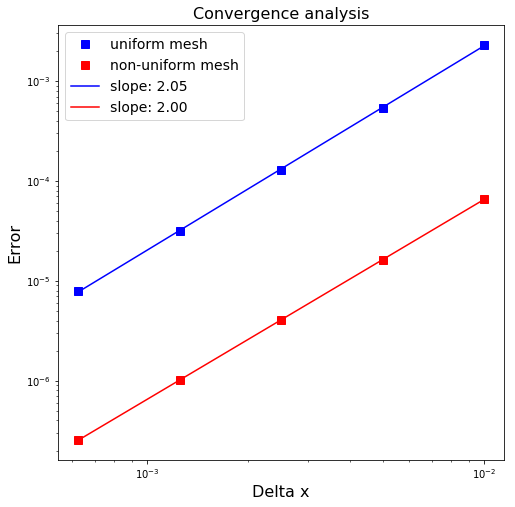

In [25]:
# parameters
L = 1.
U = 1.
Pe = 30.
kappa = 1./Pe
CE = 1.
N = 100
n_ite = 5


dx_uni_all = []
dx_var1_all = []

err_uni_all = []
err_var1_all = []

for n in range(n_ite):
    
    # define a uniform mesh
    dx = L / N
    dx_uni = dx
    x = np.linspace(-dx / 2, dx / 2 + L, N + 2)
    # get the delta x vector
    dx_ind = np.linspace(0, len(x)-2, len(x)-1)
    dx_vec = np.empty((len(dx_ind)))
    for i in range(1, len(x)):
        dx_vec[i-1] = x[i] - x[i-1]

    # call function considering uniform mesh to get numerical solution
    x_uni, C_uni = BVP_AD_central_unimesh(L, U, kappa, CE, N)



    # get the exact solution
    C_exa = CE * (np.exp(Pe * x_uni / L) - 1) / (np.exp(Pe) - 1)



    # get an optimally stretched mesh
    a = 10.  # optimal value for Pe = 30
    x_var1 = L * np.arcsinh(np.sinh(a)*x)/a

    # call the generalised function to get numerical solution
    C_var1 = BVP_AD_central(x_var1, L, U, kappa, CE, N)



    # get the errors
    C_exa = CE * (np.exp(Pe * x_uni / L) - 1) / (np.exp(Pe) - 1)
    err_uni_all.append( np.sqrt(np.mean( (C_uni - C_exa)**2 )) )
    C_exa = CE * (np.exp(Pe * x_var1 / L) - 1) / (np.exp(Pe) - 1)
    err_var1_all.append( np.sqrt(np.mean( (C_var1 - C_exa)**2 )) )

    dx_uni_all.append(dx_uni)

    N = N*2


# plot the figure of the convergence analysis

fig = plt.figure(figsize = (8, 8))
ax1 = plt.subplot(111)
ax1.loglog(dx_uni_all, err_uni_all, 'bs', label = 'uniform mesh', markersize = 8)
ax1.loglog(dx_uni_all, err_var1_all, 'rs', label = 'non-uniform mesh', markersize = 8)

# Get a linear fit to the errors using numpy.polyfit.
fit = np.polyfit(np.log(dx_uni_all), np.log(err_uni_all), 1)
ax1.loglog(dx_uni_all, np.exp(fit[1]) * dx_uni_all**(fit[0]), 'b-', label = 'slope: {:.2f}'.format(fit[0]))
fit = np.polyfit(np.log(dx_uni_all), np.log(err_var1_all), 1)
ax1.loglog(dx_uni_all, np.exp(fit[1]) * dx_uni_all**(fit[0]), 'r-', label = 'slope: {:.2f}'.format(fit[0]))

ax1.legend(loc = 'best', fontsize = 14)
ax1.set_xlabel('Delta x', fontsize = 16)
ax1.set_ylabel('Error', fontsize = 16)
ax1.set_title('Convergence analysis', fontsize = 16)

plt.show()

## Comments on the figure

The figure show convergence analysis for the solutions obtained considering uniform (blue squares) and non-uniform (red squares) meshes. The $\Delta x$ refers to the space step size of the uniform mesh. The order of convergence is the same for both solutions. The non-uniform mesh results in a significantly lower error.

## iii.

## Generate non-uniform mesh considering arclength of exact solution

The goal is to generate a non-uniform mesh in a way that the arclength of the exact solution is approximately equally distributed among the mesh points. In order to do this I first compute the appoximate length of the exact solution:

<br>
$$ al = \sum_{i=1}^{N} [(C_i - C_{i-1})^2 + (x_i - x_{i-1})^2]^\frac{1}{2}, $$
<br>

Where $N$ is the number of mesh points and $C_i$ are the values of the function at nodes $x_i$. Then I divide the total arclength equally among the space steps:

<br>
$$ a = \frac{al}{N+1} $$
<br>

I initialise the first node of the new non-uniform mesh in the same position of the first node of the uniform mesh. The second node of the non-uniform mesh is initialised at distance $a$ from the first node. This because on this node the derivative of the exact solution is very low, so $\Delta x \approx a$. In order to find the position of the following node I consider the equation:

<br>
$$ a^2 = (f(x_2) - f(x_1))^2 + (x_2 - x_{1})^2, $$
<br>

which i solve for $x_2$ considering it as a root problem and employing the Newton method. I then moved one step to the right till I find the new position for all the nodes.

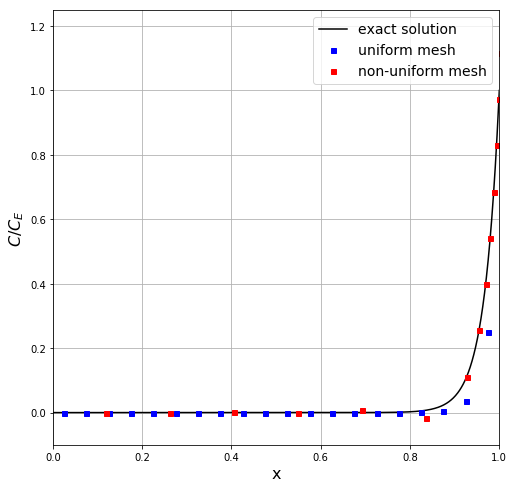

In [26]:
# parameters
L = 1.
U = 1.
Pe = 30.
kappa = 1./Pe
CE = 1.
N = 20


# define a uniform mesh
dx = L / N
x = np.linspace(-dx / 2, dx / 2 + L, N + 2)
# get the delta x vector
dx_ind = np.linspace(0, len(x)-2, len(x)-1)
dx_vec = np.empty((len(dx_ind)))
for i in range(1, len(x)):
    dx_vec[i-1] = x[i] - x[i-1]

# call function considering uniform mesh to get numerical solution
x_uni, C_uni = BVP_AD_central_unimesh(L, U, kappa, CE, N)


# construct the exact solution
C_exa = CE * (np.exp(Pe * x_uni / L) - 1) / (np.exp(Pe) - 1)


# get a non-uniform dx in a way that each dx account for the same arclength
# of the exact solution

# get total arclength
al = 0
for i in range (1, len(x_uni)):
    al += np.sqrt( (C_exa[i]-C_exa[i-1])**2 + (x_uni[i]-x_uni[i-1])**2 )

a = al / (N+1)

def f_exa(x):
    return CE * (np.exp(Pe * x / L) - 1) / (np.exp(Pe) - 1)

x_var = np.empty((len(x_uni)))

# initialize first and second node
x_var[0] = x_uni[0]
x_var[1] = x_uni[0] + a
for i in range(2, len(x_var)):
    def f(x):
        return ( f_exa(x) - f_exa(x_var[i-1]) )**2 + (x - x_var[i-1])**2 - a**2
    x_var[i] = sop.newton(f, x_var[i-1] + (x_var[i-1]-x_var[i-2]))

# Eliminate nodes beyond the right ghost node
if x_var[-1] > L:
    indexes = np.where(x_var>1)
    x_var = x_var[0: indexes[0][0]+1]

# call the generalised function to get numerical solution
C_var = BVP_AD_central(x_var, L, U, kappa, CE, len(x_var)-2)


# get the exact solution with a fine sampling
xf = np.linspace(0, L, 1000)
C_exa = CE * (np.exp(Pe * xf / L) - 1) / (np.exp(Pe) - 1)


fig = plt.figure(figsize = (8, 8))
ax1 = plt.subplot(111)
ax1.plot(xf, C_exa, 'k', label = 'exact solution', markersize = 2)
ax1.plot(x_uni, C_uni, 'bs', label = 'uniform mesh', markersize = 5)
ax1.plot(x_var, C_var, 'rs', label = 'non-uniform mesh', markersize = 5)
ax1.set_xlabel('x', fontsize = 16)
ax1.set_ylabel('$C/C_E$', fontsize = 16)
ax1.set_xlim(0, 1)
ax1.set_ylim(-0.1, 1.25)
ax1.legend(loc = 'best', fontsize = 14)
plt.grid()

plt.show()

## Convergence analysis

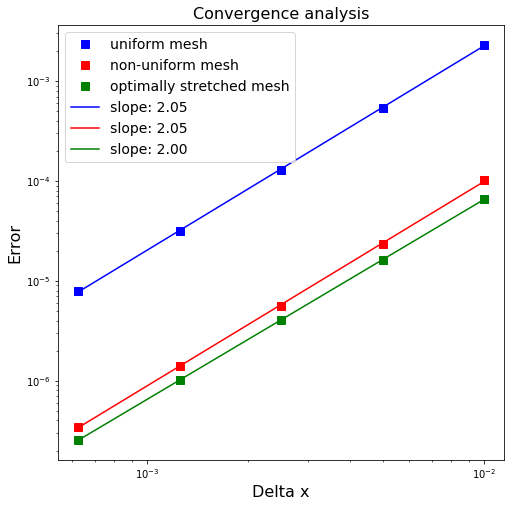

In [27]:
# parameters
L = 1.
U = 1.
Pe = 30.
kappa = 1./Pe
CE = 1.
N = 100
n_ite = 5


dx_uni_all = []
dx_var_all = []
dx_var1_all = []

err_uni_all = []
err_var_all = []
err_var1_all = []

for n in range(n_ite):
    
    # define a uniform mesh
    dx = L / N
    dx_uni = dx
    x = np.linspace(-dx / 2, dx / 2 + L, N + 2)
    # get the delta x vector
    dx_ind = np.linspace(0, len(x)-2, len(x)-1)
    dx_vec = np.empty((len(dx_ind)))
    for i in range(1, len(x)):
        dx_vec[i-1] = x[i] - x[i-1]

    # call function considering uniform mesh to get numerical solution
    x_uni, C_uni = BVP_AD_central_unimesh(L, U, kappa, CE, N)


    # get the exact solution
    C_exa = CE * (np.exp(Pe * x_uni / L) - 1) / (np.exp(Pe) - 1)


    # get a non-uniform dx in a way that each dx account for the same arclength
    # of the exact solution

    # get total arclength
    al = 0
    for i in range (1, len(x_uni)):
        al += np.sqrt( (C_exa[i]-C_exa[i-1])**2 + (x_uni[i]-x_uni[i-1])**2 )

    a = al / (N+1)

    def f_exa(x):
        return CE * (np.exp(Pe * x / L) - 1) / (np.exp(Pe) - 1)

    x_var = np.empty((len(x_uni)))

    # initialize first and second node
    x_var[0] = x_uni[0]
    x_var[1] = x_uni[0] + a
    for i in range(2, len(x_var)):
        def f(x):
            return ( f_exa(x) - f_exa(x_var[i-1]) )**2 + (x - x_var[i-1])**2 - a**2
        x_var[i] = sop.newton(f, x_var[i-1] + (x_var[i-1]-x_var[i-2]))

    # eliminate nodes beyond the right ghost node
    if x_var[-1] > L:
        indexes = np.where(x_var>1)
        x_var = x_var[0: indexes[0][0]+1]

    # call the generalised function to get numerical solution
    C_var = BVP_AD_central(x_var, L, U, kappa, CE, len(x_var)-2)


    # get an optimally stretched mesh
    a = 10.  # optimal value for Pe = 30
    x_var1 = L * np.arcsinh(np.sinh(a)*x)/a

    # call the generalised function to get numerical solution
    C_var1 = BVP_AD_central(x_var1, L, U, kappa, CE, N)


    # get the errors
    C_exa = CE * (np.exp(Pe * x_uni / L) - 1) / (np.exp(Pe) - 1)
    err_uni_all.append( np.sqrt(np.mean( (C_uni - C_exa)**2 )) )
    C_exa = CE * (np.exp(Pe * x_var / L) - 1) / (np.exp(Pe) - 1)
    err_var_all.append( np.sqrt(np.mean( (C_var - C_exa)**2 )) )
    C_exa = CE * (np.exp(Pe * x_var1 / L) - 1) / (np.exp(Pe) - 1)
    err_var1_all.append( np.sqrt(np.mean( (C_var1 - C_exa)**2 )) )

    dx_uni_all.append(dx_uni)

    N = N*2


# plot the figure of the convergence analysis

fig = plt.figure(figsize = (8, 8))
ax1 = plt.subplot(111)
ax1.loglog(dx_uni_all, err_uni_all, 'bs', label = 'uniform mesh', markersize = 8)
ax1.loglog(dx_uni_all, err_var_all, 'rs', label = 'non-uniform mesh', markersize = 8)
ax1.loglog(dx_uni_all, err_var1_all, 'gs', label = 'optimally stretched mesh', markersize = 8)

# Get a linear fit to the errors using numpy.polyfit.
fit = np.polyfit(np.log(dx_uni_all), np.log(err_uni_all), 1)
ax1.loglog(dx_uni_all, np.exp(fit[1]) * dx_uni_all**(fit[0]), 'b-', label = 'slope: {:.2f}'.format(fit[0]))
fit = np.polyfit(np.log(dx_uni_all), np.log(err_var_all), 1)
ax1.loglog(dx_uni_all, np.exp(fit[1]) * dx_uni_all**(fit[0]), 'r-', label = 'slope: {:.2f}'.format(fit[0]))
fit = np.polyfit(np.log(dx_uni_all), np.log(err_var1_all), 1)
ax1.loglog(dx_uni_all, np.exp(fit[1]) * dx_uni_all**(fit[0]), 'g-', label = 'slope: {:.2f}'.format(fit[0]))

ax1.legend(loc = 'best', fontsize = 14)
ax1.set_xlabel('Delta x', fontsize = 16)
ax1.set_ylabel('Error', fontsize = 16)
ax1.set_title('Convergence analysis', fontsize = 16)

plt.show()

## Comments on the figure

The figure shows convergence analysis for solutions obtained with uniform mesh, non-uniform mesh generated taking into account length of the exact solution, and optimally stretched mesh. The $\Delta x$ refers to the space step size of the uniform mesh. The solution obtained with the mesh that takes into account length of the exact solution has an error comparable to the one obtained with the optimally stretched mesh.

## iv.

## Generate non-uniform mesh according to local steepness of numerical solution

Here I generate a new non-uniform mesh, taking into account the local steepness of the numerial solution obtained on a uniform mesh. To do this, I calculate the derivative of the numerical solution in each space step. Where the derivative is higher then a certain tolerance value, the space step is equally subdivided in three new steps.


Re-meshing the uniform mesh:
number of iterations = 2



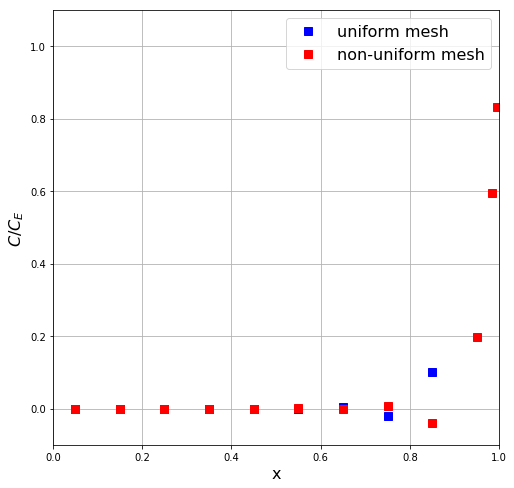

In [39]:
def remesh(x_uni, C_uni, tol):
    """
    Get a uniform mesh and modify it accordind to the local steepness of the 
    numerical solution.
    
    Parameters
    ----------
    x_uni : numpy 1D array
        Uniform space mesh.
    C_uni : numpy 1D array
        Numerical solution obtain with the uniform mesh.
    tol : float
        If the local derivative of the numerical solution is 
        higher than this, the space step is equally divided in 
        three smaller steps.

    Returns
    -------
    x_var : numpy 1D array
        Modified mesh.
    N_var : integer
        Number of space steps in the new mesh.
    """
    
    # compute derivative in between each node
    dcdx_vec = np.empty( len(x_uni)-1 )
    for i in range(1, len(x_uni)):
        dcdx_vec[i-1] = ( C_uni[i]-C_uni[i-1] ) - ( x_uni[i]-x_uni[i-1] )

    n_ite = 0
    while np.max(dcdx_vec) > tol:
        n_ite += 1

        # get a new mesh splitting in three intervals where derivative is higher then tolerance
        dx_vec = []
        for i in range(1, len(x_uni)):
            dx = x_uni[i]-x_uni[i-1]
            dcdx_vec[i-1] = ( C_uni[i]-C_uni[i-1] ) - ( x_uni[i]-x_uni[i-1] )
            if dcdx_vec[i-1] < tol:
                dx_vec.append(dx)
            else:
                dx_vec.append(dx*(1/3))
                dx_vec.append(dx*(1/3))
                dx_vec.append(dx*(1/3))
        
        # build the new mesh
        dx_vec = np.array(dx_vec)
        x_var = np.empty( len(dx_vec)+1 )
        x_var[0] = x_uni[0]
        for i in range( 1, len(x_var) ):
            x_var[i] = x_var[i-1] + dx_vec[i-1]

        # cut the new mesh in case there are more then two ghost nodes

        # cut the left side
        indexes = np.where(x_var<0)
        indexes = np.array(indexes[0][:])
        if len(indexes)>1:
            x_var = x_var[indexes[-1]:]

        # cut the right side:
        indexes = np.where(x_var>1)
        indexes = np.array(indexes[0][:])
        if len (indexes)>1:
            x_var = x_var[0:indexes[0]+1]

        # get the new number of nodes
        N_var = len(x_var)-2
        
        # Compute the new solution
        C_var = BVP_AD_central(x_var, L, U, kappa, CE, N_var)

        # update the derivative vec
        dcdx_vec = np.empty( len(x_var)-1 )
        for i in range(1, len(x_var)):
            dcdx_vec[i-1] = ( C_var[i]-C_var[i-1] ) - ( x_var[i]-x_var[i-1] )
        
        x_uni = x_var
        C_uni = C_var
    
    if n_ite==0:
        x_var = x_uni
        N_var = len(x_var)-2
        print('\n No re-meshing needed considering a tolerance = %f \n' % tol)
    else:
        print('\nRe-meshing the uniform mesh:')
        print('number of iterations = %i\n' % n_ite)

    return x_var, N_var



# parameters
L = 1.
U = 1.
Pe = 30.
kappa = 1./Pe
CE = 1.
N = 10
tol = 0.5

# get numerical solution considering a uniform mesh
x_uni, C_uni = BVP_AD_central_unimesh(L, U, kappa, CE, N)

# get numerical solution re-meshing the uniform mesh
x_var, N_var = remesh(x_uni, C_uni, tol)
C_var = BVP_AD_central(x_var, L, U, kappa, CE, N_var)

# plot
fig = plt.figure(figsize = (8, 8))
ax1 = plt.subplot(111)
ax1.plot(x_uni, C_uni, 'bs', label = 'uniform mesh', markersize = 8)
ax1.plot(x_var, C_var, 'rs', label = 'non-uniform mesh', markersize = 8)
ax1.set_xlabel('x', fontsize = 16)
ax1.set_ylabel('$C/C_E$', fontsize = 16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_xlim(0, 1)
ax1.set_ylim(-0.1, 1.1)
plt.grid()

plt.show()

In [47]:
# parameters
L = 1.
U = 1.
Pe = 30.
kappa = 1./Pe
CE = 1.
N = 50
n_ite = 6


dx_uni_all = []
dx_var_all = []
dx_var1_all = []

err_uni_all = []
err_var_all = []
err_var1_all = []
err_var2_all = []

for n in range(n_ite):
    
    # define a uniform mesh
    dx = L / N
    dx_uni = dx
    x = np.linspace(-dx / 2, dx / 2 + L, N + 2)
    # get the delta x vector
    dx_ind = np.linspace(0, len(x)-2, len(x)-1)
    dx_vec = np.empty((len(dx_ind)))
    for i in range(1, len(x)):
        dx_vec[i-1] = x[i] - x[i-1]

    # call function considering uniform mesh to get numerical solution
    x_uni, C_uni = BVP_AD_central_unimesh(L, U, kappa, CE, N)



    # get the exact solution
    C_exa = CE * (np.exp(Pe * x_uni / L) - 1) / (np.exp(Pe) - 1)



    # get a non-uniform dx in a way that each dx account for the same arclength
    # of the exact solution

    # get total arclength
    al = 0
    for i in range (1, len(x_uni)):
        al += np.sqrt( (C_exa[i]-C_exa[i-1])**2 + (x_uni[i]-x_uni[i-1])**2 )

    a = al / (N+1)

    def f_exa(x):
        return CE * (np.exp(Pe * x / L) - 1) / (np.exp(Pe) - 1)

    x_var = np.empty((len(x_uni)))

    # initialize first and second node
    x_var[0] = x_uni[0]
    x_var[1] = x_uni[0] + a
    for i in range(2, len(x_var)):
        def f(x):
            return ( f_exa(x) - f_exa(x_var[i-1]) )**2 + (x - x_var[i-1])**2 - a**2
        x_var[i] = sop.newton(f, x_var[i-1] + (x_var[i-1]-x_var[i-2]))

    # eliminate nodes beyond the right ghost node
    if x_var[-1] > L:
        indexes = np.where(x_var>1)
        x_var = x_var[0: indexes[0][0]+1]

    # call the generalised function to get numerical solution
    C_var = BVP_AD_central(x_var, L, U, kappa, CE, len(x_var)-2)



    # get an optimally stretched mesh
    a = 10.  # optimal value for Pe = 30
    x_var1 = L * np.arcsinh(np.sinh(a)*x)/a

    # call the generalised function to get numerical solution
    C_var1 = BVP_AD_central(x_var1, L, U, kappa, CE, N)



    # get numerical solution re-meshing the uniform mesh
    tol = 0.01
    x_var2, N_var2 = remesh(x_uni, C_uni, tol)
    C_var2 = BVP_AD_central(x_var2, L, U, kappa, CE, N_var2)



    # get the errors
    C_exa = CE * (np.exp(Pe * x_uni / L) - 1) / (np.exp(Pe) - 1)
    err_uni_all.append( np.sqrt(np.mean( (C_uni - C_exa)**2 )) )
    C_exa = CE * (np.exp(Pe * x_var / L) - 1) / (np.exp(Pe) - 1)
    err_var_all.append( np.sqrt(np.mean( (C_var - C_exa)**2 )) )
    C_exa = CE * (np.exp(Pe * x_var1 / L) - 1) / (np.exp(Pe) - 1)
    err_var1_all.append( np.sqrt(np.mean( (C_var1 - C_exa)**2 )) )
    C_exa = CE * (np.exp(Pe * x_var2 / L) - 1) / (np.exp(Pe) - 1)
    err_var2_all.append( np.sqrt(np.mean( (C_var2 - C_exa)**2 )) )



    dx_uni_all.append(dx_uni)
    N = N*2



Re-meshing the uniform mesh:
number of iterations = 4


Re-meshing the uniform mesh:
number of iterations = 4


Re-meshing the uniform mesh:
number of iterations = 3


Re-meshing the uniform mesh:
number of iterations = 2


Re-meshing the uniform mesh:
number of iterations = 2


Re-meshing the uniform mesh:
number of iterations = 1



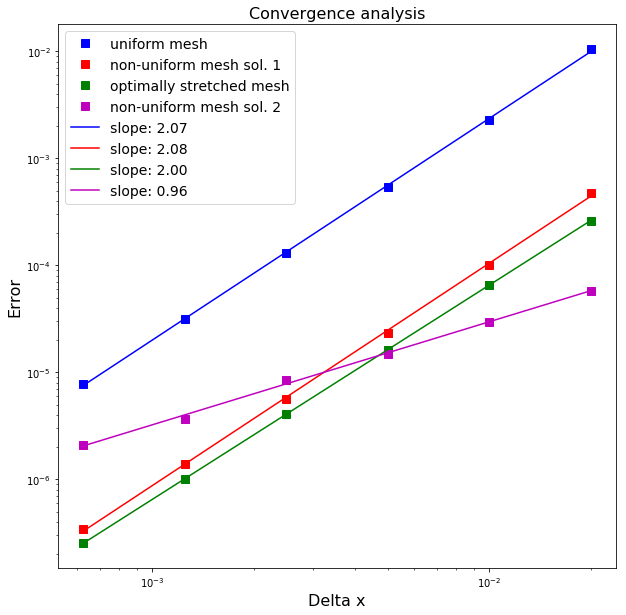

In [48]:
# plot the figure of the convergence analysis

fig = plt.figure(figsize = (10, 10))
ax1 = plt.subplot(111)
ax1.loglog(dx_uni_all, err_uni_all, 'bs', label = 'uniform mesh', markersize = 8)
ax1.loglog(dx_uni_all, err_var_all, 'rs', label = 'non-uniform mesh sol. 1', markersize = 8)
ax1.loglog(dx_uni_all, err_var1_all, 'gs', label = 'optimally stretched mesh', markersize = 8)
ax1.loglog(dx_uni_all, err_var2_all, 'ms', label = 'non-uniform mesh sol. 2', markersize = 8)

# Get a linear fit to the errors using numpy.polyfit.
fit = np.polyfit(np.log(dx_uni_all), np.log(err_uni_all), 1)
ax1.loglog(dx_uni_all, np.exp(fit[1]) * dx_uni_all**(fit[0]), 'b-', label = 'slope: {:.2f}'.format(fit[0]))
fit = np.polyfit(np.log(dx_uni_all), np.log(err_var_all), 1)
ax1.loglog(dx_uni_all, np.exp(fit[1]) * dx_uni_all**(fit[0]), 'r-', label = 'slope: {:.2f}'.format(fit[0]))
fit = np.polyfit(np.log(dx_uni_all), np.log(err_var1_all), 1)
ax1.loglog(dx_uni_all, np.exp(fit[1]) * dx_uni_all**(fit[0]), 'g-', label = 'slope: {:.2f}'.format(fit[0]))
fit = np.polyfit(np.log(dx_uni_all), np.log(err_var2_all), 1)
ax1.loglog(dx_uni_all, np.exp(fit[1]) * dx_uni_all**(fit[0]), 'm-', label = 'slope: {:.2f}'.format(fit[0]))

ax1.legend(loc = 'best', fontsize = 14)
ax1.set_xlabel('Delta x', fontsize = 16)
ax1.set_ylabel('Error', fontsize = 16)
ax1.set_title('Convergence analysis', fontsize = 16)

plt.show()

## Comments on the figure

The figure shows the convergence analysis for the various meshes developed in Coursework-2B. Non-uniform mesh solution 1 (red squares) refers to the errors of the solution obtained with the mesh that takes into account the arclength of the analytical solution. The errors of the solution obtained with the optimally stretched mesh is represented by the green squares.<br>
The purple squares are for the errors relative to the solution obtained with the last mesh, assuming no knowledge of the exact solution. The accuracy of this solution is affected by the tolerance considered, with lower tolerance giving a more accurate solution. Convergence in this case drops to one, but note that the $\Delta x$ referes to the one of the uniform mesh and it therefore represents only the maximum $\Delta x$ of this mesh. Although the order of accuracy decreases, for larger space step sizes it is possible to obtain solutions more accurate then those calculated with the optimally stretched mesh.